<a href="https://colab.research.google.com/github/mysmyst/p300/blob/main/Filtration_%26_Proc_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Comparing and Testing Filterting approaches, Time Windows and Channel Selection methods

# 1 Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mne
!pip install numexpr
!pip install python-picard
!pip install imbalanced-learn
!pip install PyWavelets
!pip install mne-features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import mne
import scipy.io
import picard
import pickle
import random
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from sklearn.linear_model import LogisticRegression,RidgeCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.preprocessing import StandardScaler
from mne_features.feature_extraction import extract_features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
import matplotlib.pyplot as plt


In [4]:
try:
  atep="/content/drive/MyDrive/BCIDATASETS/BCI_Comp_III_Wads_2004/Subject_A_Test.mat"
  scipy.io.loadmat(atep)
except:
  try:
    atep="/content/drive/MyDrive/CDAC Weekly Report/BCI_Comp_III_Wads_2004/Subject_A_Test.mat"
    scipy.io.loadmat(atep)
  except:
    print("Data could not be loaded")
  else:
    atep="/content/drive/MyDrive/CDAC Weekly Report/BCI_Comp_III_Wads_2004/Subject_A_Test.mat"
    atrp="/content/drive/MyDrive/CDAC Weekly Report/BCI_Comp_III_Wads_2004/Subject_A_Train.mat"
    btep="/content/drive/MyDrive/CDAC Weekly Report/BCI_Comp_III_Wads_2004/Subject_B_Test.mat"
    btrp="/content/drive/MyDrive/CDAC Weekly Report/BCI_Comp_III_Wads_2004/Subject_B_Train.mat"
    ate=scipy.io.loadmat(atep)
    atr=scipy.io.loadmat(atrp)
    # bte=scipy.io.loadmat(btep)
    # btr=scipy.io.loadmat(btrp)
    print("T's data loaded")
else:
  atep="/content/drive/MyDrive/BCIDATASETS/BCI_Comp_III_Wads_2004/Subject_A_Test.mat"
  atrp="/content/drive/MyDrive/BCIDATASETS/BCI_Comp_III_Wads_2004/Subject_A_Train.mat"
  btep="/content/drive/MyDrive/BCIDATASETS/BCI_Comp_III_Wads_2004/Subject_B_Test.mat"
  btrp="/content/drive/MyDrive/BCIDATASETS/BCI_Comp_III_Wads_2004/Subject_B_Train.mat"
  ate=scipy.io.loadmat(atep)
  atr=scipy.io.loadmat(atrp)
  # bte=scipy.io.loadmat(btep)
  # btr=scipy.io.loadmat(btrp)
  print("F's data loaded") 

F's data loaded


# 2 Data setup 

In [5]:
signal=atr['Signal']
tarchar=atr['TargetChar'][0]
flashing=atr['Flashing']
stimcode=atr['StimulusCode']
stimtype=atr['StimulusType']

In [6]:
for char in range(85):
  for i in range(len(flashing[0])):
    if stimcode[char,i]!=0:
      if stimtype[char,i]==1:
        stimtype[char,i]=2
      else:
        stimtype[char,i]=1

In [7]:
signal_m=signal[0]
stimcode_m=stimcode[0]
stimtype_m=stimtype[0]
for i in range(1,85):
  signal_m=np.concatenate((signal_m,signal[i]))
  stimcode_m=np.concatenate((stimcode_m,stimcode[i]))
  stimtype_m=np.concatenate((stimtype_m,stimtype[i]))

In [8]:
cn=[]

#mapping channel names to standard locations
channel = {1:'FC5',2: 'FC3',3:'FC1',4:'FCz',5:'FC2',6:'FC4',7:'FC6',8:'C5',9:'C3',10:'C1',11:'Cz',12:'C2',13:'C4',14:'C6',15:'CP5',16:'CP3',17:'CP1',18:'CPz',19:'CP2',20:'CP4',21:'CP6',22:'Fp1',23:'Fpz',24:'Fp2',25:'AF7',26:'AF3',27:'AFz',28:'AF4',29:'AF8',30:'F7',31:'F5',32:'F3',33:'F1',34:'Fz',35:'F2',36:'F4',37:'F6',38:'F8',39:'FT7',40:'FT8',41:'T7',42:'T8',43:'P9',44:'P10',45:'TP7',46:'TP8',47:'P7',48:'P5',49:'P3',50:'P1',51:'Pz',52:'P2',53:'P4',54:'P6',55:'P8',56:'PO7',57:'PO3',58:'POz',59:'PO4',60:'PO8',61:'O1',62:'Oz',63:'O2',64:'Iz'}
cn = [*channel.values()]

#channel types
ch_types= ['eeg'] * signal_m.shape[1]

#create info object for data
info=mne.create_info(cn, 240, ch_types=ch_types)


In [9]:
raw_arr = mne.io.array.RawArray(signal_m.T, info)

raw_arr.set_montage('biosemi64',on_missing='warn')

Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.


<RawArray | 64 x 662490 (2760.4 s), ~323.6 MB, data loaded>

In [10]:
print(signal_m.shape)
print(stimtype_m.shape)
stimcoden= np.expand_dims(stimcode_m,axis=1)
stimtypen = np.expand_dims(stimtype_m,axis=1)
print(stimtypen.shape)
signal_new = np.append(signal_m,stimcoden,axis=1)
signal_new = np.append(signal_new,stimtypen,axis=1)
print(signal_new.shape)

ch_names_events = cn + ['stimcode']+ ['stimtype']
ch_types_events = ch_types + ['misc'] + ['misc']

info_events = mne.create_info(ch_names_events,240, ch_types_events)

raw_arr = mne.io.RawArray(signal_new.T, info_events)
# events_arr = mne.io.RawArray(signal_new[0].T, info_events)

(662490, 64)
(662490,)
(662490, 1)
(662490, 66)
Creating RawArray with float64 data, n_channels=66, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.


In [11]:
  stimcoden = np.expand_dims(stimcode,axis=2)
  stimtypen = np.expand_dims(stimtype,axis=2)
  signew= np.append(signal,stimcoden,axis=2)
  signew = np.append(signew,stimtypen,axis=2)

In [12]:
signew.shape

(85, 7794, 66)

In [13]:
X_train_raw=list()
for i in range(signal.shape[0]):
  tempraw = mne.io.RawArray(signew[i].T, info_events)
  X_train_raw.append(tempraw)

Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
Creating RawArray with float64 data, n_channels=66, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.

# 3 Filtering

In [15]:
x_arr_1=raw_arr.copy().filter(1,20)
x_arr_1.set_montage('biosemi64',on_missing='warn')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 793 samples (3.304 sec)



<RawArray | 66 x 662490 (2760.4 s), ~333.7 MB, data loaded>

In [14]:
x_arr_2=raw_arr.copy().filter(1,40)
x_arr_2.set_montage('biosemi64',on_missing='warn')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 793 samples (3.304 sec)



<RawArray | 66 x 662490 (2760.4 s), ~333.7 MB, data loaded>

In [41]:
x_arr_3=raw_arr.copy().filter(0.1,40)
x_arr_3.set_montage('biosemi64',on_missing='warn')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 7921 samples (33.004 sec)



<RawArray | 66 x 662490 (2760.4 s), ~333.7 MB, data loaded>

# 4 Event and Epoch creation

In [15]:
events_st = mne.find_events(x_arr_2, stim_channel='stimtype', initial_event=True)

15300 events found
Event IDs: [1 2]


In [110]:
tmin1 = 0
tmax1 = 0.7

In [111]:
bline=(tmin1,tmax1)

In [21]:
epochs1 = mne.Epochs(x_arr_1, events_st, { 'n300':1, 'p300':2 }, tmin1, tmax1, baseline=bline)

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [112]:
epochs2 = mne.Epochs(x_arr_2, events_st, { 'n300':1, 'p300':2 }, tmin1, tmax1, baseline=bline)

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [42]:
epochs3 = mne.Epochs(x_arr_3, events_st, { 'n300':1, 'p300':2 }, tmin1, tmax1, baseline=bline)

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [78]:
epochs4 = mne.Epochs(raw_arr, events_st, { 'n300':1, 'p300':2 }, tmin1, tmax1, baseline=bline)

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


# 5 Data Balancing

In [16]:
from imblearn.pipeline import Pipeline

In [73]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:64,:,:]
  data3=np.empty((64,20400,169))
  for i in range(64):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [25]:
x1 = epochs1.get_data()
y1 = epochs1.events.T[2]

Using data from preloaded Raw for 15300 events and 169 original time points ...
0 bad epochs dropped


In [26]:
x2 = epochs2.get_data()
y2 = epochs2.events.T[2]

Using data from preloaded Raw for 15300 events and 169 original time points ...
0 bad epochs dropped


In [27]:
x1,y1=balanceepocheddata(x1,y1)

In [29]:
x2,y2=balanceepocheddata(x2,y2)

In [17]:
from sklearn.utils import shuffle

In [31]:
x1,y1=shuffle(x1 ,y1 , random_state=0)
x2,y2=shuffle(x2 ,y2 , random_state=0)

In [32]:
del epochs1
del epochs2
del x_arr_1
del x_arr_2

# 6 Filter Range Analysis

comparing filters by range

In [34]:
!pip install pyriemann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 567 kB/s 
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=41cf9a6069554e4e300283876bdb6dc072ab2e6a27519678286884eecf2f74db
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann


In [31]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, StratifiedKFold

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn
import pandas as pd
import seaborn as sns
from datetime import datetime as dt

from collections import OrderedDict


In [32]:
import matplotlib.pyplot as plt

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
def cfepoch(epochsdata,events):
    clfs = OrderedDict()

    clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
    clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
    clfs['Vect + RF'] = make_pipeline(Vectorizer(),StandardScaler(),RandomForestClassifier(max_depth=None, random_state=0))


    print("starting", dt.now().strftime('%d-%m-%Y, %H:%M:%S (GMT+1)'))

    # format data
    X = epochsdata
    # times = epochs.times
    y = events

    # define cross validation
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

    # run cross validation for each pipeline
    auc = []
    methods = []
    for m in clfs:
        res = cross_val_score(clfs[m], X, y==1, scoring='roc_auc', cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
        print("[{}] mean = {}/1".format(m, np.mean(res)))

    print("current ", dt.now().strftime('%d-%m-%Y, %H:%M:%S (GMT+1)'))
    results = pd.DataFrame(data=auc, columns=['(AUC)'])
    results['methods'] = methods

    plt.figure(figsize=[8,4])
    sns.barplot(data=results, x='(AUC)', y='methods', ci=None)
    plt.xlim(0, 1)
    sns.despine()

starting 29-06-2022, 07:11:37 (GMT+1)
[Vect + LR] mean = 0.6166447882600217/1
[Vect + RegLDA] mean = 0.6424602963828543/1
[Vect + RF] mean = 0.7210996365402271/1
current  29-06-2022, 07:13:00 (GMT+1)


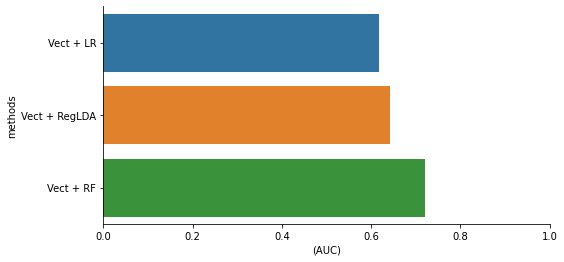

In [39]:
cfepoch(x1[:3000,:12,:],y1[:3000])

starting 29-06-2022, 07:13:14 (GMT+1)
[Vect + LR] mean = 0.638906130253663/1
[Vect + RegLDA] mean = 0.674570715310079/1
[Vect + RF] mean = 0.720702031277269/1
current  29-06-2022, 07:14:28 (GMT+1)


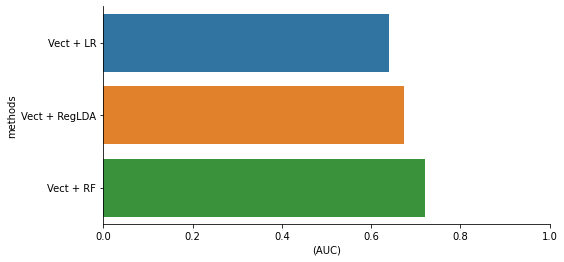

In [40]:
cfepoch(x2[:3000,:12,:],y2[:3000])

In [44]:
del x1,x2

In [43]:
x3 = epochs3.get_data()
y3 = epochs3.events.T[2]

Using data from preloaded Raw for 15300 events and 169 original time points ...
0 bad epochs dropped


In [45]:
x3,y3=balanceepocheddata(x3,y3)

In [46]:
x3,y3=shuffle(x3 ,y3 , random_state=0)

starting 29-06-2022, 07:19:09 (GMT+1)
[Vect + LR] mean = 0.6326764752748713/1
[Vect + RegLDA] mean = 0.6671846663985613/1
[Vect + RF] mean = 0.7211398523397249/1
current  29-06-2022, 07:20:38 (GMT+1)


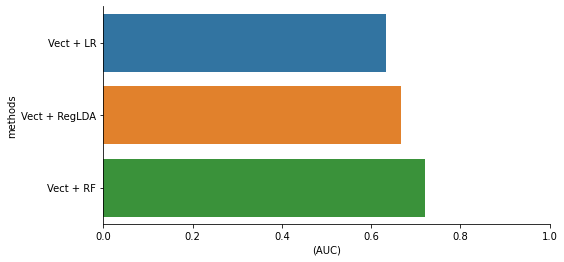

In [47]:
cfepoch(x3[:3000,:12,:],y3[:3000])

In [52]:
import math

In [69]:
v1=(0.6166447882600217+0.6424602963828543+0.7210996365402271)/3
v2=(0.638906130253663+0.674570715310079+0.720702031277269)/3
v3=(0.6326764752748713+0.6671846663985613+0.7211398523397249)/3

Average accuracy of Bandpass Filters by range

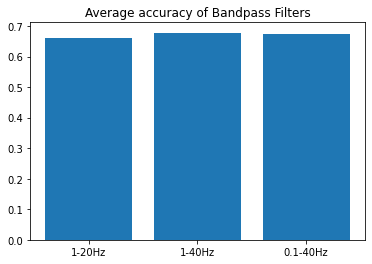

In [70]:
names = ['1-20Hz', '1-40Hz', '0.1-40Hz']
values = [v1,v2,v3]
plt.title('Average accuracy of Bandpass Filters')

plt.bar(names, values)

plt.show()

In [73]:
for i in values:
  print(i)

0.6600682403943677
0.6780596256136704
0.6736669980043858


# 7 Filter Order Analysis

slope analysis of filters

2 -0.010590189078479643
3 -0.01097545041595937
4 -0.011063203404488298
5 -0.011068977096922119
6 -0.011050621405086076
7 -0.011026108195840826
8 -0.011001420249456134
9 -0.01097850772671124


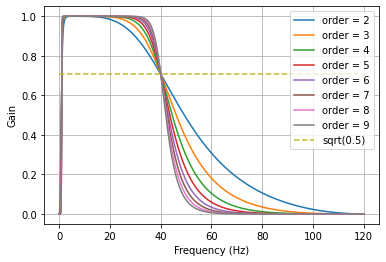

In [75]:
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np
import matplotlib.pyplot as plt

s_freq = 240
lfreq_r = 1
hfreq_r = 40

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
    y = sosfilt(sos, data)
    return y

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [2, 3, 4, 5, 6, 7, 8, 9]:
    sos = butter(order, [lfreq_r, hfreq_r], fs = s_freq, btype='band', output='sos')
    w, h = sosfreqz(sos, fs=s_freq, worN=2000)
    slope, intercept = np.polyfit(w, abs(h),1)
    print(order, slope)
    plt.plot(w, abs(h), label="order = %d" % order)
    y = sosfilt(sos,signal)

plt.plot([0, 0.5 * s_freq], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [79]:
del epochs3
del x3
del y3

In [81]:
x4 = epochs4.get_data()
y4 = epochs4.events.T[2]

Using data from preloaded Raw for 15300 events and 169 original time points ...
0 bad epochs dropped


In [82]:
x4,y4=balanceepocheddata(x4,y4)

In [83]:
x4,y4=shuffle(x4 ,y4 , random_state=0)

In [84]:
X_2 = butter_bandpass_filter(x4, lfreq_r, hfreq_r, s_freq, order=2)
X_3 = butter_bandpass_filter(x4, lfreq_r, hfreq_r, s_freq, order=3)


comparison of different order filters

starting 29-06-2022, 08:17:24 (GMT+1)
[Vect + LR] mean = 0.6397210692849934/1
[Vect + RegLDA] mean = 0.6788396603661914/1
[Vect + RF] mean = 0.7323297088527874/1
current  29-06-2022, 08:18:59 (GMT+1)


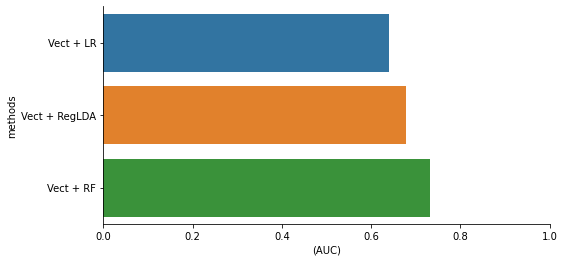

In [85]:
cfepoch(X_2[:3000,:12,:],y4[:3000])

starting 29-06-2022, 08:18:59 (GMT+1)
[Vect + LR] mean = 0.6365675435734394/1
[Vect + RegLDA] mean = 0.6747391663947674/1
[Vect + RF] mean = 0.7342198514291784/1
current  29-06-2022, 08:20:35 (GMT+1)


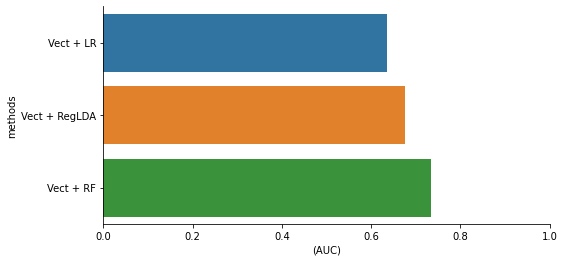

In [86]:
cfepoch(X_3[:3000,:12,:],y4[:3000])

In [87]:
del X_2
del X_3

In [88]:
X_4 = butter_bandpass_filter(x4, lfreq_r, hfreq_r, s_freq, order=4)
X_5 = butter_bandpass_filter(x4, lfreq_r, hfreq_r, s_freq, order=5)


starting 29-06-2022, 08:22:22 (GMT+1)
[Vect + LR] mean = 0.6384022945769374/1
[Vect + RegLDA] mean = 0.6703002526766271/1
[Vect + RF] mean = 0.7163078860906449/1
current  29-06-2022, 08:23:35 (GMT+1)


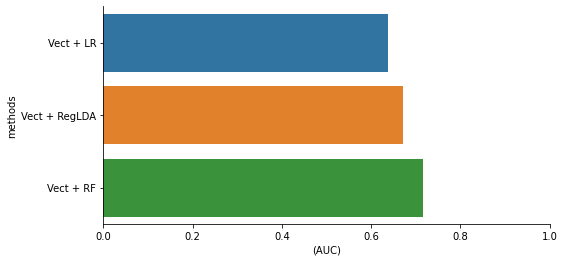

In [90]:
cfepoch(X_4[:3000,:12,:],y4[:3000])

In [91]:
del X_4

starting 29-06-2022, 08:23:49 (GMT+1)
[Vect + LR] mean = 0.6352654622161182/1
[Vect + RegLDA] mean = 0.6656200441615006/1
[Vect + RF] mean = 0.7249208962811767/1
current  29-06-2022, 08:25:03 (GMT+1)


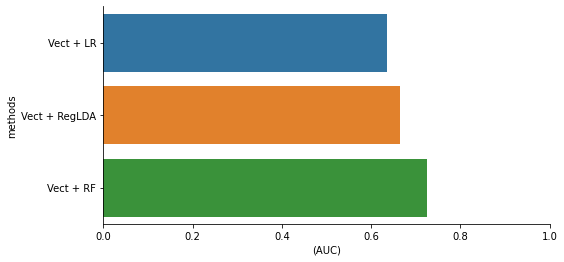

In [92]:
cfepoch(X_5[:3000,:12,:],y4[:3000])

In [93]:
del X_5

In [94]:
X_6 = butter_bandpass_filter(x4, lfreq_r, hfreq_r, s_freq, order=6)

starting 29-06-2022, 08:25:31 (GMT+1)
[Vect + LR] mean = 0.6310071402013825/1
[Vect + RegLDA] mean = 0.6620173155574441/1
[Vect + RF] mean = 0.7269612790141817/1
current  29-06-2022, 08:26:46 (GMT+1)


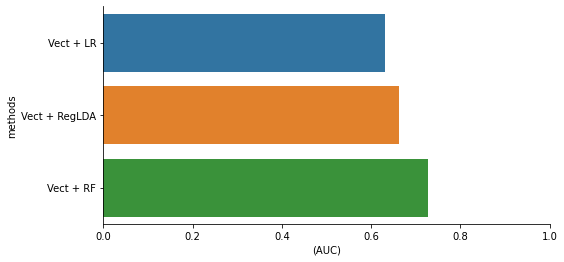

In [95]:
cfepoch(X_6[:3000,:12,:],y4[:3000])

In [111]:
del X_6

Average accuracy of Bandpass Filters by order

In [96]:
avgs=[(0.6397210692849934+0.6788396603661914+0.7323297088527874)/3,(0.6365675435734394+0.6747391663947674+0.7342198514291784)/3,(0.6384022945769374+0.6703002526766271+0.7163078860906449)/3,(0.6352654622161182+0.6656200441615006+0.7249208962811767)/3,(0.6310071402013825+0.6620173155574441+0.7269612790141817)/3]

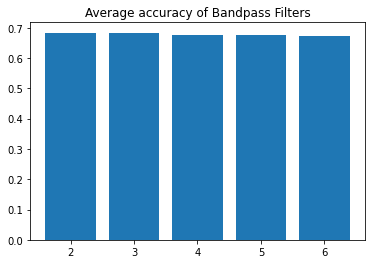

In [97]:
names = ['2', '3', '4', '5', '6']
values = avgs
plt.title('Average accuracy of Bandpass Filters')

plt.bar(names, values)

plt.show()

In [98]:
for i in avgs:
  print(i)

0.6836301461679907
0.6818421871324617
0.6750034777814031
0.6752688008862652
0.6733285782576695


# 8 Time Window Analysis

In [18]:
x_arr_2=raw_arr.copy().filter(1,40)
x_arr_2.set_montage('biosemi64',on_missing='warn')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 793 samples (3.304 sec)



<RawArray | 66 x 662490 (2760.4 s), ~333.7 MB, data loaded>

In [19]:
epochsa = mne.Epochs(x_arr_2, events_st, { 'n300':1, 'p300':2 }, 0, 0.7, baseline=(0,0.7))

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [101]:
evoked = epochsa.average()

In [102]:
p300s = epochsa['p300'].average()
n300s = epochsa['n300'].average()

In [103]:
l=[]
for i in range(64):
  l.append(i)

average p300 signal shape

['p300']
Need more than one channel to make topography for eeg. Disabling interactivity.


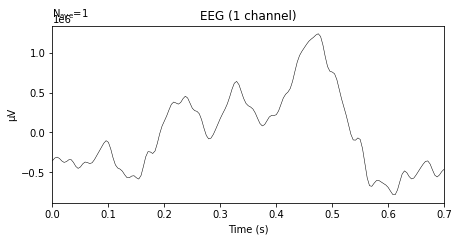

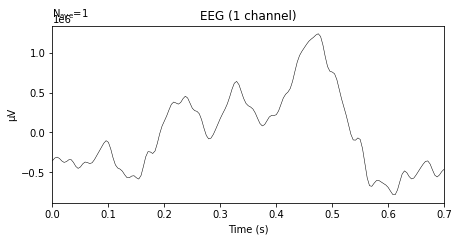

In [104]:
roi_dict = dict(p300=l)
roi_evoked = mne.channels.combine_channels(p300s, roi_dict, method='mean')
print(roi_evoked.info['ch_names'])
roi_evoked.plot()

average non p300 signal shape

['p300']
Need more than one channel to make topography for eeg. Disabling interactivity.


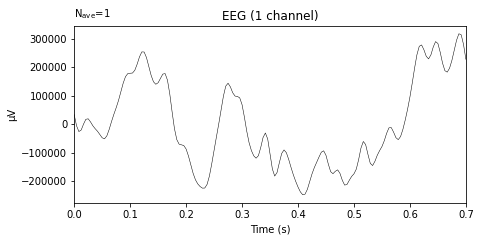

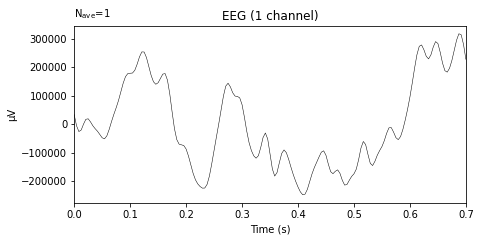

In [105]:
roi_dict = dict(p300=l)
roi_evoked = mne.channels.combine_channels(n300s, roi_dict, method='mean')
print(roi_evoked.info['ch_names'])
roi_evoked.plot()

In [108]:
xa = epochsa.get_data()
ya = epochsa.events.T[2]
xa,ya=balanceepocheddata(xa,ya)
xa,ya=shuffle(xa ,ya , random_state=0)

Using data from preloaded Raw for 15300 events and 169 original time points ...


comparing time windows

starting 29-06-2022, 09:06:10 (GMT+1)
[Vect + LR] mean = 0.638906130253663/1
[Vect + RegLDA] mean = 0.674570715310079/1
[Vect + RF] mean = 0.720702031277269/1
current  29-06-2022, 09:07:32 (GMT+1)


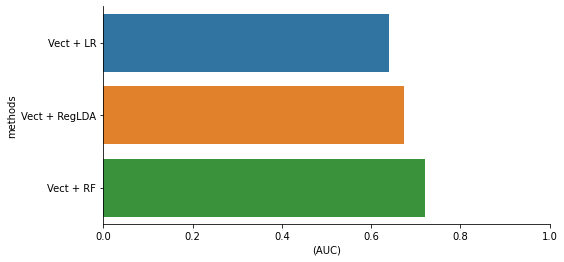

In [109]:
cfepoch(xa[:3000,:12,:],ya[:3000])

In [110]:
del xa
del ya
del epochsa

In [115]:
epochsb = mne.Epochs(x_arr_2, events_st, { 'n300':1, 'p300':2 }, 0.3, 0.7, baseline=(0.3,0.7))

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [117]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:64,:,:]
  data3=np.empty((64,20400,97))
  for i in range(64):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [118]:
xb = epochsb.get_data()
yb = epochsb.events.T[2]
xb,yb=balanceepocheddata(xb,yb)
xb,yb=shuffle(xb ,yb , random_state=0)

Using data from preloaded Raw for 15300 events and 97 original time points ...


starting 29-06-2022, 09:11:39 (GMT+1)
[Vect + LR] mean = 0.6220761975582181/1
[Vect + RegLDA] mean = 0.6371639514678767/1
[Vect + RF] mean = 0.7031216565874238/1
current  29-06-2022, 09:12:18 (GMT+1)


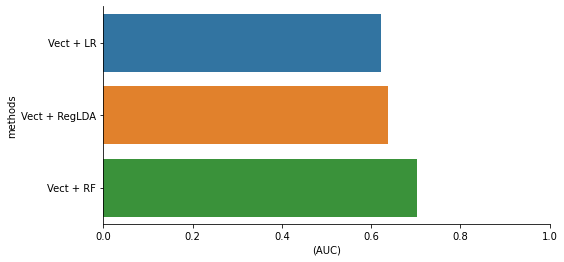

In [119]:
cfepoch(xb[:3000,:12,:],yb[:3000])

In [120]:
del xb
del yb
del epochsb

In [121]:
epochsc = mne.Epochs(x_arr_2, events_st, { 'n300':1, 'p300':2 }, 0.2, 0.7, baseline=(0.2,0.7))

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [123]:
epochsc.get_data().shape

Using data from preloaded Raw for 15300 events and 121 original time points ...
0 bad epochs dropped


(15300, 66, 121)

In [124]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:64,:,:]
  data3=np.empty((64,20400,121))
  for i in range(64):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [125]:
xc = epochsc.get_data()
yc = epochsc.events.T[2]
xc,yc=balanceepocheddata(xc,yc)
xc,yc=shuffle(xc ,yc , random_state=0)

Using data from preloaded Raw for 15300 events and 121 original time points ...


starting 29-06-2022, 09:15:02 (GMT+1)
[Vect + LR] mean = 0.6309449195304616/1
[Vect + RegLDA] mean = 0.6511954715492188/1
[Vect + RF] mean = 0.7058024569577127/1
current  29-06-2022, 09:15:52 (GMT+1)


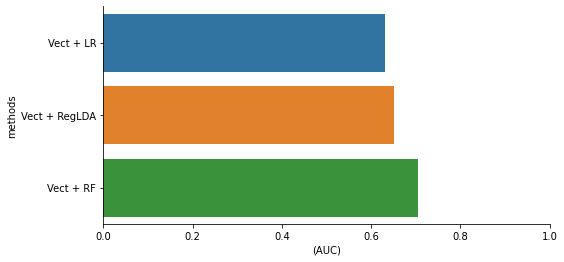

In [126]:
cfepoch(xc[:3000,:12,:],yc[:3000])

In [127]:
del xc
del yc
del epochsc

In [18]:
epochsd = mne.Epochs(x_arr_2, events_st, { 'n300':1, 'p300':2 }, 0, 1.0, baseline=(0,1.0))

Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [19]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:64,:,:]
  data3=np.empty((64,20400,241))
  for i in range(64):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [21]:
from imblearn.pipeline import Pipeline

In [22]:
xd = epochsd.get_data()
yd = epochsd.events.T[2]
xd,yd=balanceepocheddata(xd,yd)


Using data from preloaded Raw for 15300 events and 241 original time points ...


NameError: ignored

In [23]:
from sklearn.utils import shuffle

In [24]:
xd,yd=shuffle(xd,yd , random_state=0)

In [25]:
del epochsd

starting 29-06-2022, 09:25:03 (GMT+1)
[Vect + LR] mean = 0.624168936709437/1


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Vect + RegLDA] mean = 0.6621963896835092/1
[Vect + RF] mean = 0.7258504124016419/1
current  29-06-2022, 09:27:19 (GMT+1)


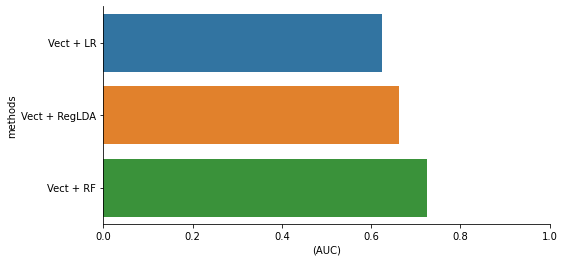

In [32]:
cfepoch(xd[:3000,:12,:],yd[:3000])

In [33]:
winavg=[(0.638906130253663+ 0.674570715310079+0.720702031277269)/3,(0.6220761975582181+0.6371639514678767+0.7031216565874238)/3,(0.6309449195304616+0.6511954715492188+0.7058024569577127)/3,(0.624168936709437+0.6621963896835092+0.7258504124016419)/3]

Average accuracy of Window Sizes

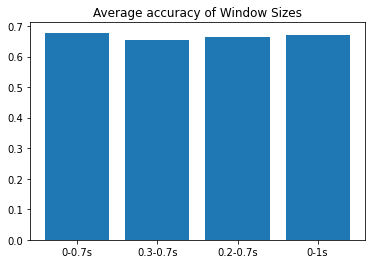

In [36]:
names = ['0-0.7s', '0.3-0.7s', '0.2-0.7s','0-1s']
values = winavg
plt.title('Average accuracy of Window Sizes')

plt.bar(names, values)

plt.show()

In [35]:
for i in winavg:
  print(i)

0.6780596256136704
0.6541206018711728
0.6626476160124644
0.670738579598196


# 9 Channel Selection Analysis

Channel Feature Importances calculated through permutation

In [ ]:
# model = RandomForestClassifier(max_depth=None, random_state=0)


# y = y2[:600]
# data = data3[:600,:,:]

In [ ]:
# scaler=StandardScaler()

In [ ]:
# X_n=np.reshape(data,(600,64*169))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size = 0.30)

In [ ]:
# model.fit(X_train,y_train)

In [ ]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
# )

# forest_importances = pd.Series(np.mean(np.reshape(result.importances_mean,(64,169)),axis=1,keepdims=False), index=feature_names)

In [ ]:
# fis=np.mean(np.reshape(result.importances_std,(64,169)),axis=1,keepdims=False)

In [ ]:
# for i in range(len(fis)):
#   print(i, fis[i])

In [ ]:
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=fis, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

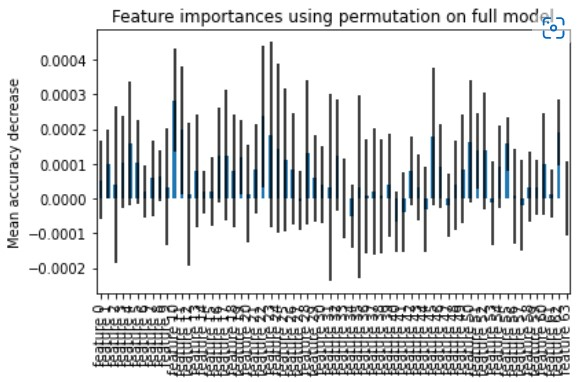

loading saved results due to large run time

In [116]:
with open("/content/drive/MyDrive/BCIDATASETS/colabdata/c_imp_b.pkl", 'rb') as f:
  res=pickle.load(f)

In [50]:
for i in res:
  print(i[0]-1,end=',')

14,61,6,8,55,59,27,40,34,47,62,43,15,42,1,58,19,63,7,51,30,0,41,33,54,53,46,5,44,29,21,48,57,3,56,16,20,60,10,39,49,32,26,18,13,38,36,9,52,50,4,37,11,17,45,22,12,25,28,2,24,35,23,31,

### Compare channels based on feature importance scores

selecting 6 channels from the top and bottom

In [46]:
epochsa.get_data().shape

Using data from preloaded Raw for 15300 events and 169 original time points ...
0 bad epochs dropped


(15300, 66, 169)

In [ ]:
# 14,61,6,8,55,59

In [ ]:
# 28,2,24,35,23,31

In [62]:
t=[6,8,14,55,59,61]

In [60]:
etop=np.zeros(shape=(15300,6,169))

In [25]:
ed=epochsa.get_data()

Using data from preloaded Raw for 15300 events and 169 original time points ...
0 bad epochs dropped


In [66]:
for i in range(15300):
  for j in range(6):
    for k in range(169):
      etop[i][j][k]=ed[i][t[j]][k]

In [67]:
etop.shape

(15300, 6, 169)

In [68]:
ebot=np.zeros(shape=(15300,6,169))

In [69]:
b=[2,23,24,28,31,35]

In [70]:
for i in range(15300):
  for j in range(6):
    for k in range(169):
      ebot[i][j][k]=ed[i][b[j]][k]

In [71]:
ebot.shape

(15300, 6, 169)

In [78]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:6,:,:]
  data3=np.empty((6,20400,169))
  for i in range(6):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [79]:
xa = etop
ya = epochsa.events.T[2]
xa,ya=balanceepocheddata(xa,ya)
xa,ya=shuffle(xa ,ya , random_state=0)

starting 29-06-2022, 10:07:10 (GMT+1)
[Vect + LR] mean = 0.6701287664372597/1
[Vect + RegLDA] mean = 0.6930715006563523/1
[Vect + RF] mean = 0.7125837512994257/1
current  29-06-2022, 10:08:05 (GMT+1)


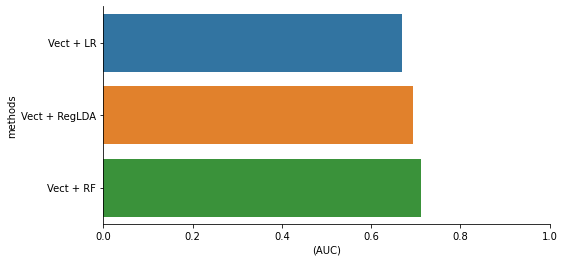

In [80]:
cfepoch(xa[:3000],ya[:3000])

In [82]:
xb = ebot
yb = epochsa.events.T[2]
xb,yb=balanceepocheddata(xb,yb)
xb,yb=shuffle(xb ,yb , random_state=0)

starting 29-06-2022, 10:08:18 (GMT+1)
[Vect + LR] mean = 0.6295017034805636/1
[Vect + RegLDA] mean = 0.648726373217795/1
[Vect + RF] mean = 0.6960315352571155/1
current  29-06-2022, 10:08:57 (GMT+1)


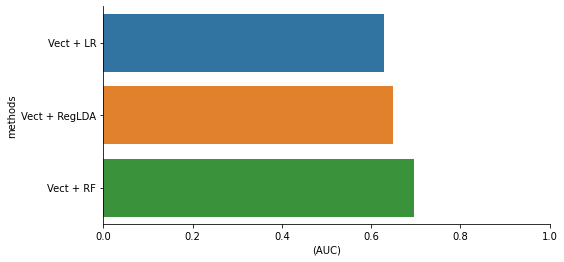

In [83]:
cfepoch(xb[:3000],yb[:3000])

average acc first channels

In [84]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:64,:,:]
  data3=np.empty((64,20400,169))
  for i in range(64):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [85]:
xc = epochsa.get_data()
yc = epochsa.events.T[2]
xc,yc=balanceepocheddata(xc,yc)
xc,yc=shuffle(xc ,yc , random_state=0)

Using data from preloaded Raw for 15300 events and 169 original time points ...


starting 29-06-2022, 10:11:52 (GMT+1)
[Vect + LR] mean = 0.6351622669570298/1
[Vect + RegLDA] mean = 0.655840775785536/1
[Vect + RF] mean = 0.7161879974808217/1
current  29-06-2022, 10:12:25 (GMT+1)


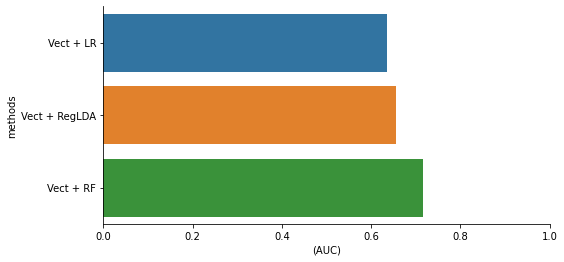

In [86]:
cfepoch(xc[:3000,:6,:],yc[:3000])

In [92]:
avgcn=[(0.6701287664372597+0.6930715006563523+0.7125837512994257)/3,(0.6295017034805636+0.648726373217795+0.6960315352571155)/3,(0.6351622669570298+0.655840775785536+0.7161879974808217)/3]

In [93]:
for i in avgcn:
  print(i)

0.6919280061310126
0.6580865373184914
0.6690636800744625


Average accuracy of Channel sets

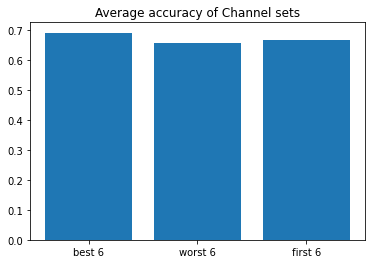

In [94]:
names = ['best 6', 'worst 6', 'first 6']
values = avgcn
plt.title('Average accuracy of Channel sets')

plt.bar(names, values)

plt.show()

### number of channels

12

In [ ]:
# 14,61,6,8,55,59,27,40,34,47,62,43,15,42,1,58,19,63,7,51,30,0,41,33,54,53,46,5,44,29,21,48,57,3,56,16,20,60,10,39,49,32,26,18,13,38,36,9,52,50,4,37,11,17,45,22,12,25,28,2,24,35,23,31,

In [20]:
etop=np.zeros(shape=(15300,12,169))

In [21]:
t0=[14,61,6,8,55,59,27,40,34,47,62,43]

In [26]:
for i in range(15300):
  for j in range(12):
    for k in range(169):
      etop[i][j][k]=ed[i][t0[j]][k]

In [27]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:12,:,:]
  data3=np.empty((12,20400,169))
  for i in range(12):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [28]:
xe = etop
ye = epochsa.events.T[2]
xe,ye=balanceepocheddata(xe,ye)
xe,ye=shuffle(xe ,ye , random_state=0)

In [29]:
del etop

starting 29-06-2022, 12:52:13 (GMT+1)
[Vect + LR] mean = 0.669105919310413/1
[Vect + RegLDA] mean = 0.7079103718823271/1
[Vect + RF] mean = 0.710045603199053/1
current  29-06-2022, 12:53:32 (GMT+1)


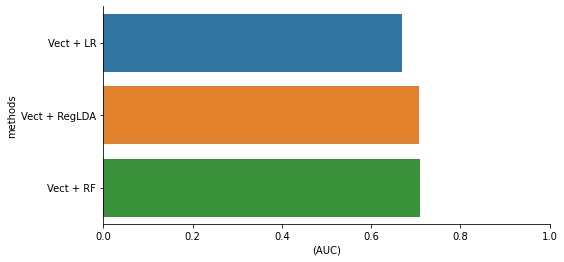

In [35]:
cfepoch(xe[:3000,:12,:],ye[:3000])

24

In [135]:
etop=np.zeros(shape=(15300,24,169))

In [122]:
t2=[14,61,6,8,55,59,27,40,34,47,62,43,15,42,1,58,19,63,7,51,30,0,41,33]

In [136]:
for i in range(15300):
  for j in range(24):
    for k in range(169):
      etop[i][j][k]=ed[i][t2[j]][k]

In [129]:
def balanceepocheddata(data,labels):
  over = SMOTE(sampling_strategy=0.6,random_state=0)
  under = RandomUnderSampler(sampling_strategy=0.6,random_state=0)

  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  
  data2=np.moveaxis(data,1,0)
  data2=data2[:24,:,:]
  data3=np.empty((24,20400,169))
  for i in range(24):
    x2,y2 = pipeline.fit_resample(data2[i], labels)
    data3[i]=x2
  
  data3=np.moveaxis(data3,1,0)

  return data3,y2

In [137]:
xd = etop
yd = epochsa.events.T[2]
xd,yd=balanceepocheddata(xd,yd)
xd,yd=shuffle(xd ,yd , random_state=0)

starting 29-06-2022, 12:24:14 (GMT+1)
[Vect + LR] mean = 0.6905098301072168/1


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Vect + RegLDA] mean = 0.7327622183945549/1
[Vect + RF] mean = 0.7160802494897145/1
current  29-06-2022, 12:29:09 (GMT+1)


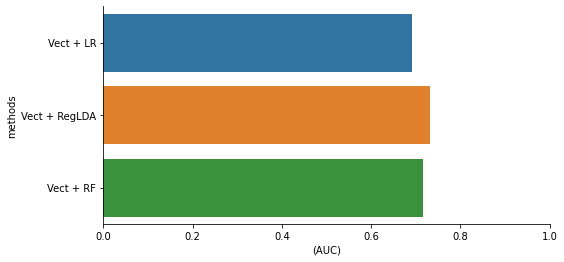

In [138]:
cfepoch(xd[:3000,:24,:],yd[:3000])

In [139]:
del etop
del xd
del yd

Average accuracy of num of channels

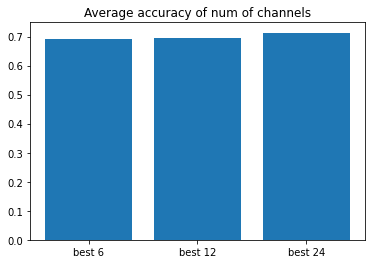

In [37]:
names = ['best 6','best 12','best 24']
values = [0.6919280061310126,(0.669105919310413+0.7079103718823271+0.710045603199053)/3,(0.6905098301072168+0.7327622183945549+0.7160802494897145)/3]
plt.title('Average accuracy of num of channels')

plt.bar(names, values)

plt.show()

48 (crashed due to lack of ram)